In [1]:
from typing import List, Dict
from tqdm import tqdm

# Analyse sur le hors domaine Vulgate

## Objectifs

Évaluer et visualiser les résultats sur la vulgate

## Chargement du corpus GOLD

In [2]:
GOLD: List[List[Dict[str, str]]] = [[]]
with open("../../../proiel-to-lasla/nt-manual.aligned.tsv") as f:
    for line_no, line in enumerate(f):
        line = line.strip().split("\t")
        if line_no == 0:
            headers = line
        elif len(line) <= 1:
            GOLD.append([])
        else:
            line = dict(zip(headers, line))
            if line["encl"] == "#Enclitic":
                if not len(GOLD[-1]):
                    GOLD.pop(-1)
                GOLD[-1][-1]["form"] = GOLD[-1][-1]["form"] + line["form"]
                GOLD[-1][-1]["lemma"] = GOLD[-1][-1]["lemma"] + "界" + line["lemma"]
                continue
            
            GOLD[-1].append(line)

GOLD = [g for g in GOLD if len(g)]

## Reparse morphology for evaluation

In [3]:
TEMP = []
TASKS = "lemma,Deg,Numb,Person,Mood_Tense_Voice,Case,Gend,pos".split(",")
for sentence in tqdm(GOLD):
    temp_sentence = []
    for token in sentence:
        new_token = {task: "_" for task in TASKS}
        new_token.update({
            "form": token["form"],
            "lemma": token["lemma"].lower(),
            # No POS distinction
            "pos": token["POS"].replace("com", "").replace("pro", "")
        })
        # No disambiguation at the lemmatizer lever
        if new_token["lemma"][-1].isnumeric():
            new_token["lemma"] = new_token["lemma"][:-1]
            
        # Treat morph as separate tasks
        for morph in token["morph"].split("|"):
            task, value = morph.split("=")
            new_token[task] = value
        temp_sentence.append(new_token)
        new_token["Mood_Tense_Voice"] = "|".join([
            new_token.get(task, "_")
            for task in ("Mood", "Tense", "Voice")
        ]).replace("_|_|_", "_")
    TEMP.append(temp_sentence)
GOLD = TEMP

100%|██████████| 11850/11850 [00:00<00:00, 33298.03it/s]


## Obtention des données (formes uniquement)

In [4]:
TOKENS = [
    [x["form"] for x in sentence]
    for sentence in GOLD
]

## Test

In [5]:
from pie.tagger import Tagger
from pie.utils import chunks
DEVICE = "cpu"
BATCH_SIZE = 128


OUTPUT = []
MODEL_PATH = "../../../latin-lasla-models/model.tar"

tagger = Tagger(device="cpu", batch_size=100, lower=True, tokenize=False)
tagger.add_model(MODEL_PATH, *TASKS)


for chunk in tqdm(chunks([(sent, len(sent)) for sent in TOKENS], tagger.batch_size)):
    tagged, tasks = tagger.tag(*zip(*chunk))
    OUTPUT.extend([
        [
            (token, dict(zip(tasks, result)))
            for token, result in sentence
        ]
        for sentence in tagged
    ])

2020-06-04 13:54:49,542 : Model ../../../latin-lasla-models/model.tar was serialized with a previous version of `pie`. This might result in issues. Model commit is 050815e, whereas current `pie` commit is 51d48f75.
119it [02:50,  1.44s/it]


## Evaluation

In [6]:
from collections import defaultdict, Counter
RESULTS = []
RAW_SCORES = {
    task: ([], []) # Pred, Truth
    for task in TASKS
}
RAW_SCORES_NOT_EMPTY = {
    task: ([], []) # Pred, Truth
    for task in TASKS
}
ERRORS = {
    task: defaultdict(lambda: defaultdict(Counter))#{truth: {pred: {token: int}} # (token, pred, truth)
    for task in tasks
}
for p_sent, t_sent in zip(OUTPUT, GOLD):
    score_sentence = []
    for (_, p_tags), (t_tags) in zip(p_sent, t_sent):
        token = t_tags["form"]
        p_tags["lemma"] = p_tags["lemma"].lower()
        score_sentence.append((
            p_tags,
            t_tags,
            {task: p_tags[task] == t_tags[task] for task in TASKS}
        ))
        for task in tasks:
            RAW_SCORES[task][0].append(p_tags[task])
            RAW_SCORES[task][1].append(t_tags[task])
            if t_tags[task] != "_":
                RAW_SCORES_NOT_EMPTY[task][0].append(p_tags[task])
                RAW_SCORES_NOT_EMPTY[task][1].append(t_tags[task])
            if t_tags[task] != p_tags[task]:
                ERRORS[task][t_tags[task]][p_tags[task]][token] += 1
    RESULTS.append(score_sentence)

In [7]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tabulate import tabulate

data = [["Task", "Accuracy", "Accuracy on V != _"]]


for task, (pred, truth) in RAW_SCORES.items():
    (pred_limited, truth_limited) = RAW_SCORES_NOT_EMPTY[task]
    data.append([
        task,
        "{0:.2f}".format(accuracy_score(truth, pred)),
        "{0:.2f}".format(accuracy_score(pred_limited, truth_limited))
    ])
print(tabulate(data))

----------------  --------  ------------------
Task              Accuracy  Accuracy on V != _
lemma             0.94      0.94
Deg               0.97      0.75
Numb              0.97      0.96
Person            0.99      0.99
Mood_Tense_Voice  0.97      0.89
Case              0.93      0.87
Gend              0.90      0.62
pos               0.94      0.94
----------------  --------  ------------------


In [8]:
ERRORS["lemma"]

with open("1.4.X-Vulgate-Lemma-Confusion.tsv", "w") as f:
    f.write("lemma\tprediction\ttoken\tnumber\n")
    for lemma in ERRORS["lemma"]:
        for pred in ERRORS["lemma"][lemma]:
            for token, count in ERRORS["lemma"][lemma][pred].items():
                f.write(f"{lemma}\t{pred}\t{token}\t{count}\n")

## Visualisation sur le corpus

In [9]:
from math import ceil
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# Compute the accuracy on splits
        
SPLITS_TASK = {
    task: []
    for task in RAW_SCORES
}
DIVIDE_BY = round(sum([len(x) for x in GOLD]) / 20) # 5%

for task, (pred, truth) in RAW_SCORES.items():
    for chunk_pred, chunk_truth in zip(chunks(pred, n=DIVIDE_BY), chunks(truth, n=DIVIDE_BY)):
        SPLITS_TASK[task].append(accuracy_score(chunk_truth, chunk_pred))
        

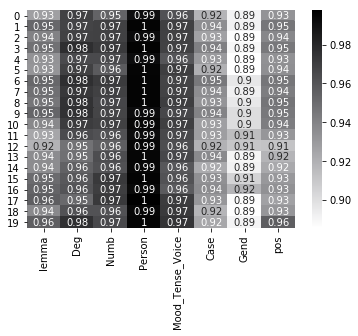

In [10]:
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

x = DataFrame(SPLITS_TASK)

cmap = sns.cubehelix_palette(250, hue=0.05, rot=0, light=1, dark=0, as_cmap=True)
sns.heatmap(x, annot=True, cmap=cmap)

## Erreurs sur les noms propres bibliques

In [13]:
BIBLICAL_PROPER_NOUNS = []
with open("../../../proiel-to-lasla/ProielToLasla.tsv") as f:
    for line_no, line in enumerate(f):
        line = line.strip().split("\t")
        if line_no == 0:
            headers = line
        else:
            line = dict(zip(headers, line))
            BIBLICAL_PROPER_NOUNS.append(line["Lemma in Forcellini"].lower())

NEW_LEMMA = []
with open("../../../proiel-to-lasla/ProielToLaslaNouns.tsv") as f:
    for line_no, line in enumerate(f):
        line = line.strip().split("\t")
        if line_no == 0:
            headers = line
        else:
            line = dict(zip(headers, line))
            lemma = line["LASLA"].lower()
            if lemma:
                if lemma[-1].isnumeric():
                    lemma = lemma[:-1]
                NEW_LEMMA.append(lemma)    

data = [["Task", "Accuracy", "Support", "Impact on global accuracy"]]
props_only = list(
    zip(*[
        (t, p) for p, t in zip(*RAW_SCORES["lemma"]) if t in BIBLICAL_PROPER_NOUNS
    ])
)
new_lemma_only = list(
    zip(*[
        (t, p) for p, t in zip(*RAW_SCORES["lemma"]) if t in NEW_LEMMA
    ])
)
data.append([
    "Lemma (Biblical Proper Nouns)",
    "{0:.2f}".format(accuracy_score(*props_only)),
    "{0}".format(len(props_only[0])),
    "-{0:.3f}".format((1-accuracy_score(*props_only))*len(props_only[0])/len(RAW_SCORES["lemma"][0]))
])
data.append([
    "Lemma created for the Vulgate",
    "{0:.2f}".format(accuracy_score(*new_lemma_only)),
    "{0}".format(len(new_lemma_only[0])),
    "-{0:.3f}".format(
        (1-accuracy_score(*new_lemma_only))*len(new_lemma_only[0]) / \
        len(RAW_SCORES["lemma"][0]))
])
print(tabulate(data))

-----------------------------  --------  -------  -------------------------
Task                           Accuracy  Support  Impact on global accuracy
Lemma (Biblical Proper Nouns)  0.32      1951     -0.012
Lemma created for the Vulgate  0.74      3403     -0.008
-----------------------------  --------  -------  -------------------------
